# EE798 FISA: Assignment

## Analyzing without replacing Nan values:

Given the data of open pit mining in Singrauli, we start by analyzing the data without replacing NaN values and working with whatever data that is present with us.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas.plotting
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
%matplotlib inline

In [2]:
data = pd.read_csv(r"C:\Users\HP\Downloads\ee798q_ass\Open pit blasting.csv",index_col = 0, header = 0)
df = pd.DataFrame(data)
df.columns = [ 'From', 'To', 'PM10 (µg/m3)', 'PM2.5 (µg/m3)', 'NO (µg/m3)', 'NO2 (µg/m3)', 'NOX (ppb)', 'CO (mg/m3)', 'SO2 (µg/m3)', 'NH3 (µg/m3)', 'OZONE (µg/m3)', 'BENZENE (µg/m3)']
df.fillna(0, inplace = True)
df = df[:-3]
df['From'] = pd.to_datetime(df['From'], format = '%Y-%m-%d %H:%M:%S')
df.drop(['To'], axis=1, inplace=True)

<IPython.core.display.Javascript object>


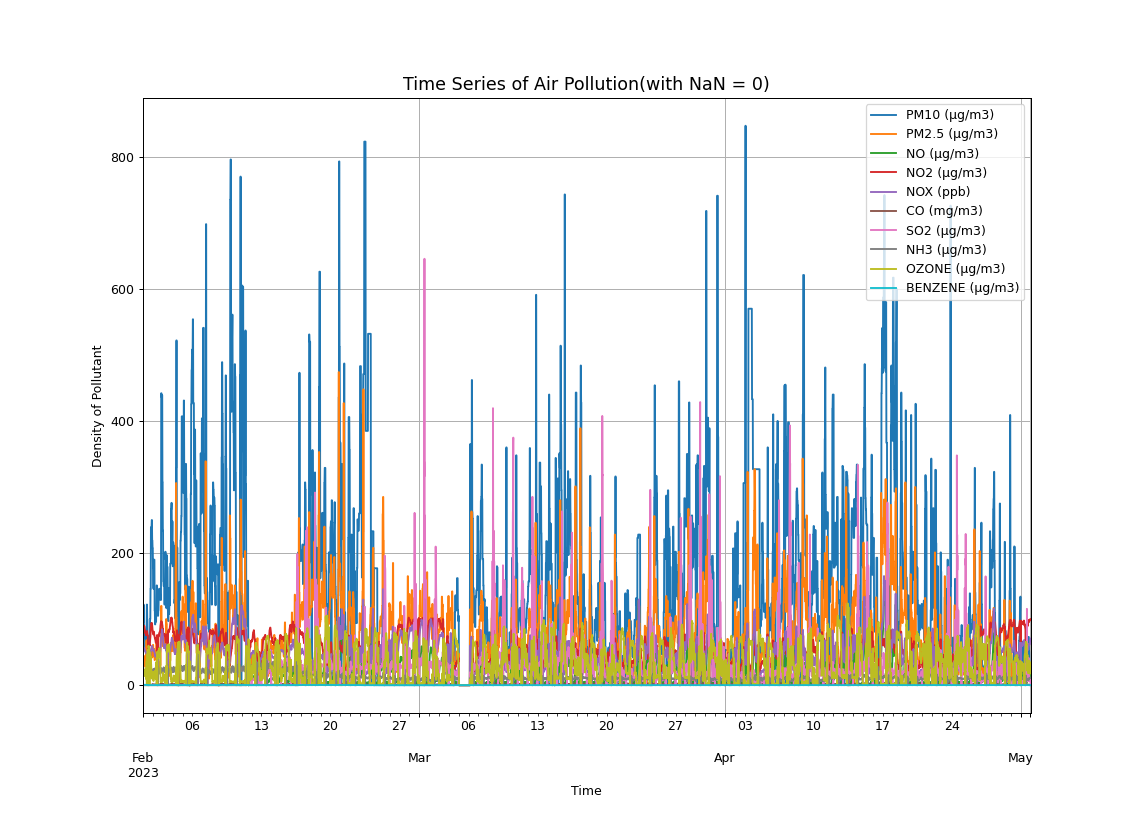

In [3]:
%matplotlib notebook
df.set_index(['From'], inplace = True)
df.plot()
plt.xlabel('Time')
plt.ylabel('Density of Pollutant')
plt.title('Time Series of Air Pollution(with NaN = 0)', fontsize = 14)
plt.grid()
plt.legend(loc=1)

In [4]:
time_stamp = df.index[7990]
msk = (df.index <= time_stamp)
df_train = df[msk].copy()
df_test = df[~msk].copy()

<IPython.core.display.Javascript object>


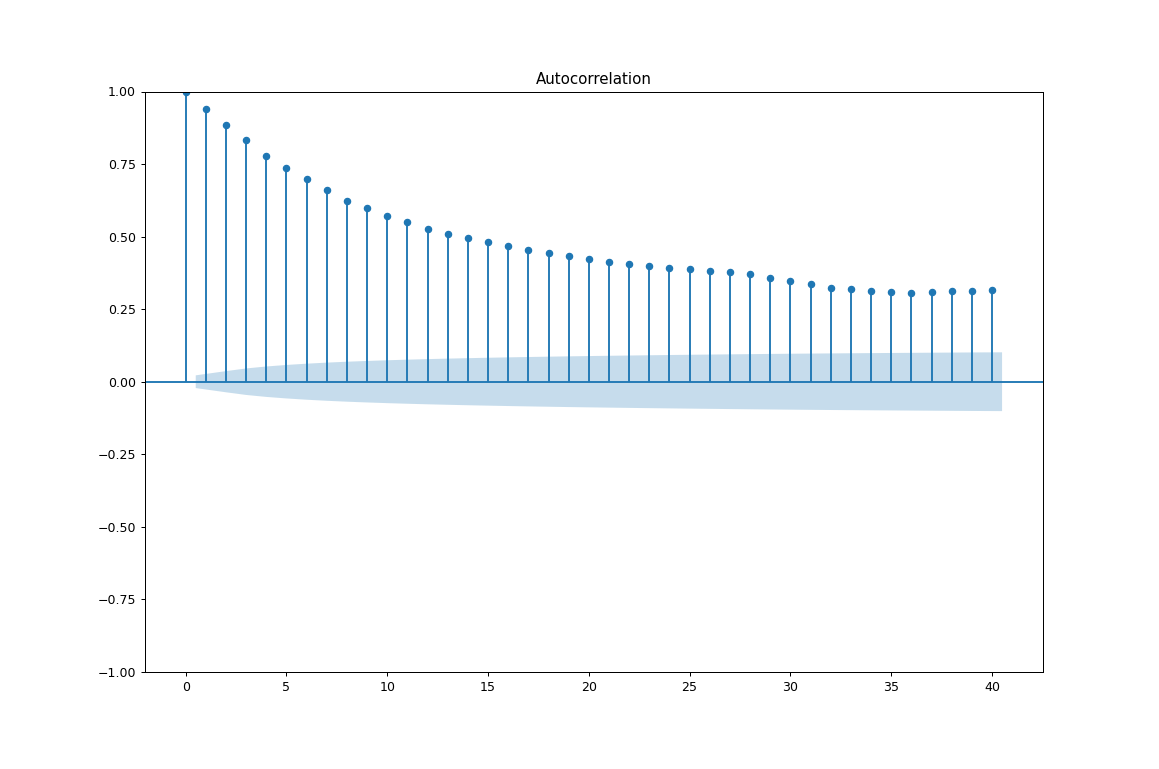

<IPython.core.display.Javascript object>


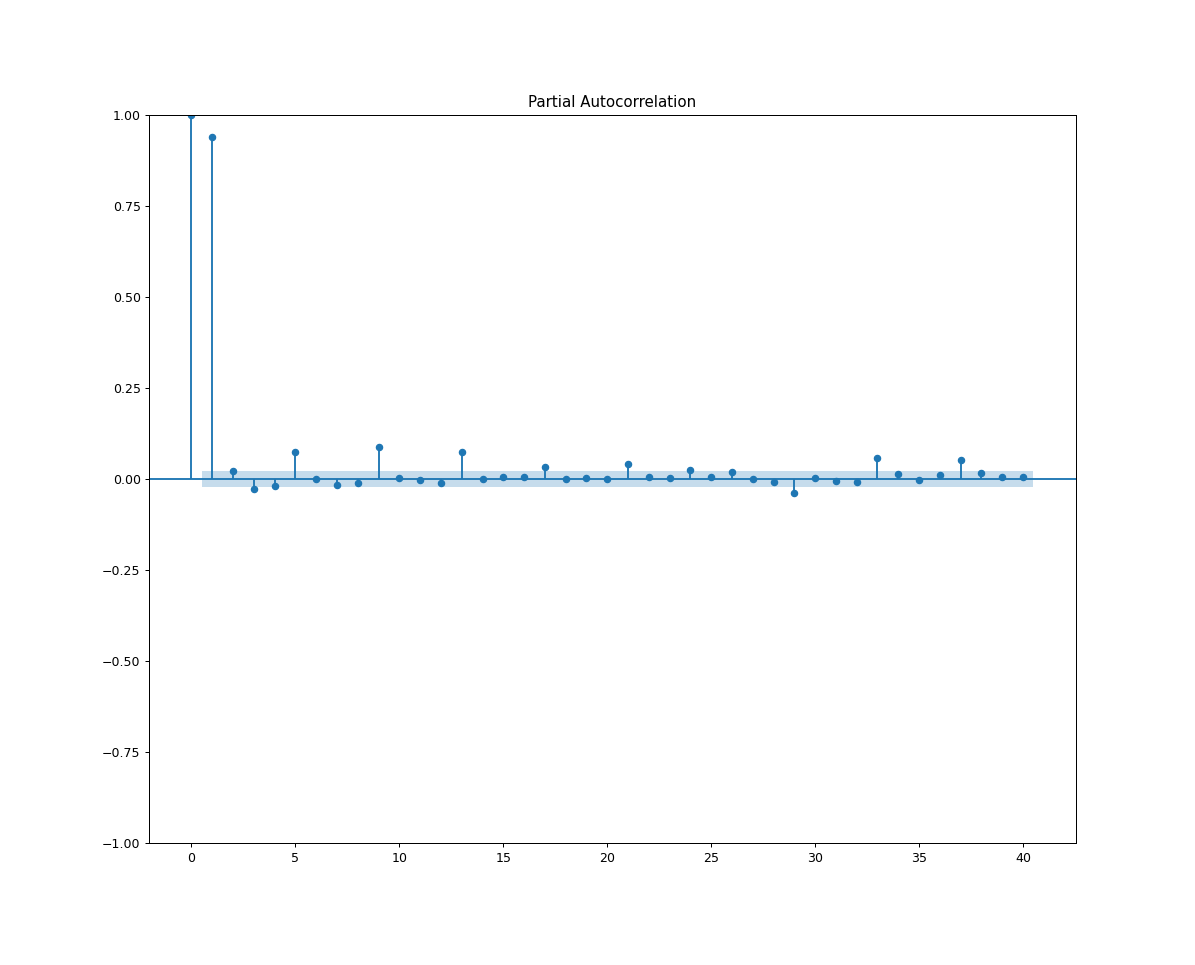

In [5]:
acf_plt = plot_acf(df_train['PM10 (µg/m3)'])
pacf_plt = plot_pacf(df_train['PM10 (µg/m3)'], method = 'ywm')

In [6]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(df_train['PM10 (µg/m3)'])
print(f'p-value is: {adf_test[1]}')

p-value is: 6.736266472733613e-12


In [8]:
pip install pmdarima

In [9]:
from pmdarima.arima import auto_arima

def arimamodel(timeseriesarray):
    autoarima_model = auto_arima(timeseriesarray, 
                              start_p=0, 
                              start_q=0,
                              max_p=5, max_q=2,
                              d=0,
                              test="adf",
                              trace=True)
    return autoarima_model
arima_model = arimamodel(df_train['PM10 (µg/m3)'])
arima_model.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=102152.001, Time=0.16 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=84997.939, Time=0.37 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=94625.239, Time=2.18 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=108094.119, Time=0.07 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=84995.807, Time=0.40 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=84991.728, Time=0.54 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=84991.034, Time=0.71 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=84949.683, Time=0.92 sec
 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=84951.725, Time=4.20 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=84950.581, Time=9.12 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=85057.859, Time=0.38 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0] intercept
Total fit time: 19.068 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 7991
Model:               SARIMAX(5, 0, 0)   Log Likelihood              -42467.841
Date:                Wed, 28 Jun 2023   AIC                          84949.683
Time:                        16:16:24   BIC                          84998.585
Sample:                    02-01-2023   HQIC                         84966.422
                         - 04-25-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      8.6417      1.351      6.397      0.000       5.994      11.289
ar.L1          0.9200      0.008    110.777      0.000       0.904       0.936
ar.L2          0.0497      0.037      1.360      0.174      -0.022       0.121
ar.L3         -0.0143      0.039     -0.365      0.715      -0.091       0.063
ar.L4         -0.0859      0.016     -5.450      0.000      -0.117      -0.055
ar.L5          0.0734      0.004     18.769      0.000       0.066       0.081
sigma2      2419.5671     11.358    213.024      0.000    2397.305    2441.829
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):           1032527.25
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.16   Skew:                             0.45
Prob(H) (two-sided):                  0.00   Kurtosis:                        58.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [10]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
test_auto = arima_model.predict(n_periods=len(df_test['PM10 (µg/m3)']))
mae = mean_absolute_error(df_test['PM10 (µg/m3)'], test_auto)
mape = mean_absolute_percentage_error(df_test['PM10 (µg/m3)'], test_auto)
rmse = np.sqrt(mean_squared_error(df_test['PM10 (µg/m3)'], test_auto))

print(f'mae - auto: {mae}')
print(f'mape - auto: {mape}')
print(f'rmse - auto: {rmse}')

mae - auto: 92.63106232341053
mape - auto: 1051289031754685.0
rmse - auto: 101.33755817038784


Mape very large so cant replace nan with 0, a better strategy would be to replace it with mean value of that column.